# Spam Ham Detection -(NLP Natural Language Processing)

In [1]:
import nltk

In [ ]:
# nltk.download_shell()

## Get the Data

In [2]:
messages=[line.rstrip() for line in open(r'smsspamcollection/SMSSpamCollection')]
print(len(messages))

5574


A collection of texts is also sometimes called "corpus". Let's print the first ten messages and number them using **enumerate**:

In [4]:
for mesg_no,message in enumerate(messages[:10]):
    print(mesg_no,message)
    print("\n")

0 ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...


1 ham	Ok lar... Joking wif u oni...


2 spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's


3 ham	U dun say so early hor... U c already then say...


4 ham	Nah I don't think he goes to usf, he lives around here though


5 spam	FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, Â£1.50 to rcv


6 ham	Even my brother is not like to speak with me. They treat me like aids patent.


7 ham	As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune


8 spam	WINNER!! As a valued network customer you have been selected to receivea Â£900 prize reward! To claim call 09061701461. Claim cod

In [6]:
messages[0]

'ham\tGo until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...'

Due to the spacing we can tell that this is a [TSV] ("tab separated values") file, where the first column is a label saying whether the given message is a normal message (commonly known as "ham") or "spam". The second column is the message itself. (Note our numbers aren't part of the file, they are just from the **enumerate** call).

Using these labeled ham and spam examples, we'll **train a machine learning model to learn to discriminate between ham/spam automatically**. Then, with a trained model, we'll be able to **classify arbitrary unlabeled messages** as ham or spam.

### Instead of parsing TSV manually using Python, we can just take advantage of pandas!

In [7]:
import pandas as pd

We'll use **read_csv** and make note of the **sep** argument, we can also specify the desired column names by passing in a list of *names*.

In [9]:
messages=pd.read_csv(r'smsspamcollection\SMSSpamCollection',
                    names=['label','message'],sep='\t')

In [12]:
messages.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## Exploratory Data Analysis

In [13]:
messages.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


Let's use **groupby** to use describe by label, this way we can begin to think about the features that separate ham and spam!

In [14]:
messages.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

As we continue our analysis we want to start thinking about the features we are going to be using. This goes along with the general idea of [feature engineering]. The better your domain knowledge on the data, the better your ability to engineer more features from it. Feature engineering is a very large part of spam detection in general. I encourage you to read up on the topic!

Let's make a new column to detect how long the text messages are:

In [15]:
messages['length']=messages['message'].apply(len)

In [16]:
messages.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


### Data Visualization

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

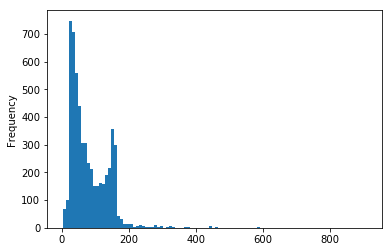

In [19]:
messages['length'].plot.hist(bins=100)

In [20]:
messages['length'].describe()

count    5572.000000
mean       80.489950
std        59.942907
min         2.000000
25%        36.000000
50%        62.000000
75%       122.000000
max       910.000000
Name: length, dtype: float64

In [23]:
messages[messages['length']==910]['message'].iloc[0]

"For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don't have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell later.."

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001F93292E3C8>,
      dtype=object)

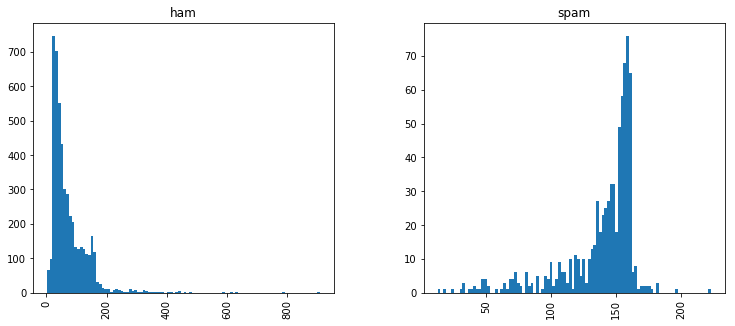

In [24]:
messages.hist(column='length',by='label',bins=100,figsize=(12,5))

Through just basic EDA we've been able to discover a trend that spam messages tend to have more characters.

Now let's begin to process the data so we can eventually use it with SciKit Learn!

## Text Pre-processing

Our main issue with our data is that it is all in text format (strings). The classification algorithms that we've learned about so far will need some sort of numerical feature vector in order to perform the classification task. There are actually many methods to convert a corpus to a vector format. The simplest is the the [bag-of-words] approach, where each unique word in a text will be represented by one number.


In this section we'll convert the raw messages (sequence of characters) into vectors (sequences of numbers).

As a first step, let's write a function that will split a message into its individual words and return a list. We'll also remove very common words, ('the', 'a', etc..). To do this we will take advantage of the NLTK library. It's pretty much the standard library in Python for processing text and has a lot of useful features.

Let's create a function that will process the string in the message column, then we can just use **apply()** in pandas do process all the text in the DataFrame.

First removing punctuation. We can just take advantage of Python's built-in **string** library to get a quick list of all the possible punctuation:

In [26]:
import string

mess = 'Sample message! Notice: it has punctuation.'

# Check characters to see if they are in punctuation
nopunc = [char for char in mess if char not in string.punctuation]

# Join the characters again to form the string.
nopunc = ''.join(nopunc)

Now let's see how to remove stopwords. We can impot a list of english stopwords from NLTK.

In [27]:
from nltk.corpus import stopwords
stopwords.words('english')[0:10] # Show some stop words

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [23]:
nopuc=[c for c in mess if c not in string.punctuation]
nopuc=''.join(nopuc)
nopuc

'Just a Sample message  to tell how to remove punctuation'

In [28]:
nopunc.split()

['Sample', 'message', 'Notice', 'it', 'has', 'punctuation']

In [29]:
# Now just remove any stopwords
clean_mess = [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [30]:
clean_mess

['Sample', 'message', 'Notice', 'punctuation']

Now let's put both of these together in a function to apply it to our DataFrame later on:

In [31]:
def text_process(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in mess if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

Here is the original DataFrame again:

In [33]:
messages.head(5)

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


Now let's "tokenize" these messages. Tokenization is just the term used to describe the process of converting the normal text strings in to a list of tokens (words that we actually want).

In [35]:
# Check to make sure its working
messages['message'].head(5).apply(text_process)

0    [Go, jurong, point, crazy, Available, bugis, n...
1                       [Ok, lar, Joking, wif, u, oni]
2    [Free, entry, 2, wkly, comp, win, FA, Cup, fin...
3        [U, dun, say, early, hor, U, c, already, say]
4    [Nah, dont, think, goes, usf, lives, around, t...
Name: message, dtype: object

## Vectorization

Currently, we have the messages as lists of tokens and now we need to convert each of those messages into a vector the SciKit Learn's algorithm models can work with.

Now we'll convert each message, represented as a list of tokens above, into a vector that machine learning models can understand.

We'll do that in three steps using the bag-of-words model:

1. Count how many times does a word occur in each message (Known as term frequency)

2. Weigh the counts, so that frequent tokens get lower weight (inverse document frequency)

3. Normalize the vectors to unit length, to abstract from the original text length (L2 norm)

Let's begin the first step:

Each vector will have as many dimensions as there are unique words in the SMS corpus.  We will first use SciKit Learn's **CountVectorizer**. This model will convert a collection of text documents to a matrix of token counts.

We can imagine this as a 2-Dimensional matrix. Where the 1-dimension is the entire vocabulary (1 row per word) and the other dimension are the actual documents, in this case a column per text message. 

For example:

<table border = “1“>
<tr>
<th></th> <th>Message 1</th> <th>Message 2</th> <th>...</th> <th>Message N</th> 
</tr>
<tr>
<td><b>Word 1 Count</b></td><td>0</td><td>1</td><td>...</td><td>0</td>
</tr>
<tr>
<td><b>Word 2 Count</b></td><td>0</td><td>0</td><td>...</td><td>0</td>
</tr>
<tr>
<td><b>...</b></td> <td>1</td><td>2</td><td>...</td><td>0</td>
</tr>
<tr>
<td><b>Word N Count</b></td> <td>0</td><td>1</td><td>...</td><td>1</td>
</tr>
</table>


Since there are so many messages, we can expect a lot of zero counts for the presence of that word in that document. Because of this, SciKit Learn will output a [Sparse Matrix].

In [37]:
from sklearn.feature_extraction.text import CountVectorizer

There are a lot of arguments and parameters that can be passed to the CountVectorizer. In this case we will just specify the **analyzer** to be our own previously defined function:

In [39]:
# Might take awhile...
bow_transformer = CountVectorizer(analyzer=text_process).fit(messages['message'])

# Print total number of vocab words
print(len(bow_transformer.vocabulary_))

11425


Let's take one text message and get its bag-of-words counts as a vector, putting to use our new `bow_transformer`:

In [40]:
message4 = messages['message'][3]
print(message4)

U dun say so early hor... U c already then say...


Now let's see its vector representation:

In [41]:
bow4 = bow_transformer.transform([message4])
print(bow4)
print(bow4.shape)

  (0, 4068)	2
  (0, 4629)	1
  (0, 5261)	1
  (0, 6204)	1
  (0, 6222)	1
  (0, 7186)	1
  (0, 9554)	2
(1, 11425)


This means that there are seven unique words in message number 4 (after removing common stop words). Two of them appear twice, the rest only once. Let's go ahead and check and confirm which ones appear twice:

In [43]:
print(bow_transformer.get_feature_names()[4068])
print(bow_transformer.get_feature_names()[9554])

U
say


Now we can use **.transform** on our Bag-of-Words (bow) transformed object and transform the entire DataFrame of messages. Let's go ahead and check out how the bag-of-words counts for the entire SMS corpus is a large, sparse matrix:

In [44]:
messages_bow = bow_transformer.transform(messages['message'])

In [45]:
print('Shape of Sparse Matrix: ', messages_bow.shape)
print('Amount of Non-Zero occurences: ', messages_bow.nnz)

Shape of Sparse Matrix:  (5572, 11425)
Amount of Non-Zero occurences:  50548


In [46]:
sparsity = (100.0 * messages_bow.nnz / (messages_bow.shape[0] * messages_bow.shape[1]))
print('sparsity: {}'.format(round(sparsity)))

sparsity: 0


In [47]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer().fit(messages_bow)
tfidf4 = tfidf_transformer.transform(bow4)
print(tfidf4)

  (0, 9554)	0.5385626262927564
  (0, 7186)	0.4389365653379857
  (0, 6222)	0.3187216892949149
  (0, 6204)	0.29953799723697416
  (0, 5261)	0.29729957405868723
  (0, 4629)	0.26619801906087187
  (0, 4068)	0.40832589933384067


We'll go ahead and check what is the IDF (inverse document frequency) of the word `"u"` and of word `"university"`?

In [48]:
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['u']])
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['university']])

3.2800524267409408
8.527076498901426


To transform the entire bag-of-words corpus into TF-IDF corpus at once:

In [49]:
messages_tfidf = tfidf_transformer.transform(messages_bow)
print(messages_tfidf.shape)

(5572, 11425)


## Training a model

In [51]:
from sklearn.naive_bayes import MultinomialNB
spam_detect_model = MultinomialNB().fit(messages_tfidf, messages['label'])

Let's try classifying our single random message and checking how we do:

In [53]:
print('predicted:', spam_detect_model.predict(tfidf4)[0])
print('expected:', messages.label[3])

predicted: ham
expected: ham


## Train Test Split

In [56]:
from sklearn.model_selection import train_test_split

msg_train, msg_test, label_train, label_test = \
train_test_split(messages['message'], messages['label'], test_size=0.2)

print(len(msg_train), len(msg_test), len(msg_train) + len(msg_test))

4457 1115 5572


The test size is 20% of the entire dataset (1115 messages out of total 5572), and the training is the rest (4457 out of 5572). Note the default split would have been 30/70.

## Creating a Data Pipeline

Let's run our model again and then predict off the test set. We will use SciKit Learn's [pipeline](http://scikit-learn.org/stable/modules/pipeline.html) capabilities to store a pipeline of workflow. This will allow us to set up all the transformations that we will do to the data for future use. Let's see an example of how it works:

In [57]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

Now we can directly pass message text data and the pipeline will do our pre-processing for us! We can treat it as a model/estimator API:

In [58]:
pipeline.fit(msg_train,label_train)

Pipeline(memory=None,
     steps=[('bow', CountVectorizer(analyzer=<function text_process at 0x000001F9314321E0>,
        binary=False, decode_error='strict', dtype=<class 'numpy.int64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 1), preprocesso...f=False, use_idf=True)), ('classifier', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

## Model Evaluation

In [59]:
predictions = pipeline.predict(msg_test)

In [61]:
from sklearn.metrics import classification_report
print(classification_report(predictions,label_test))

             precision    recall  f1-score   support

        ham       1.00      0.96      0.98      1001
       spam       0.75      1.00      0.86       114

avg / total       0.97      0.97      0.97      1115

